In [1]:
from PIL import Image
import numpy as np

In [2]:
image_raw = Image.open("peppers.bmp")

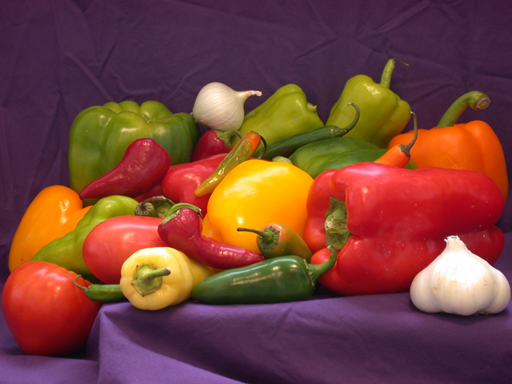

In [3]:
image_raw

In [4]:
IMG_SIZE = (320,240)

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

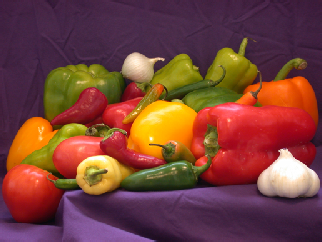

In [5]:
Image.fromarray(image_array_padded, 'RGB')

In [6]:
red_array_padded = image_array_padded[:, :, 0]
green_array_padded = image_array_padded[:, :, 1]
blue_array_padded = image_array_padded[:, :, 2]

rbg_array_padded = np.dstack((green_array_padded, blue_array_padded, red_array_padded))

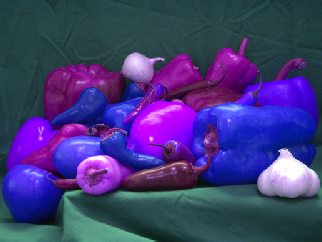

In [7]:
Image.fromarray(rbg_array_padded, 'RGB')

In [8]:
from pynq import Overlay
from pynq import Xlnk

overlay = Overlay("pynq_z2_image_sharpen.bit")

In [9]:
overlay?

In [10]:
# Make an Xlnk instance to control memory allocation
xlnk = Xlnk()

# Input array for DMA use
in_dma_array  = xlnk.cma_array(shape=(IMG_SIZE[1]+2, IMG_SIZE[0]+2, 4), dtype=np.uint8)

# Output array for DMA use
out_dma_array = xlnk.cma_array(shape=(IMG_SIZE[1],IMG_SIZE[0], 4), dtype=np.uint8)

In [11]:
def do_sharpen(image_array, intensity = 0):

    # Set overlay threshold
    overlay.sharpeningfilter.write(0, intensity)
    
    # Copy image array into dma buffer
    in_dma_array[:, :, :3] = image_array[:, :, :]
       
    # Perform DMA transfers in both directions
    overlay.axi_dma.recvchannel.transfer(out_dma_array)
    overlay.axi_dma.sendchannel.transfer(in_dma_array)
    overlay.axi_dma.sendchannel.wait()
    overlay.axi_dma.recvchannel.wait()
    
    # Return processed image array from PL 
    return out_dma_array

In [15]:
image_output = do_sharpen(rbg_array_padded, intensity = 0)

In [16]:
red_output = image_output[:, :, 2]
blue_output = image_output[:, :, 1]
green_output = image_output[:, :, 0]

rgb_output = np.dstack((red_output, green_output, blue_output))

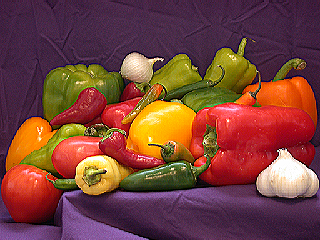

In [17]:
Image.fromarray(rgb_output, mode='RGB')

In [18]:
%%timeit
image_output = do_sharpen(rbg_array_padded, intensity = 0)

10 loops, best of 3: 74 ms per loop
